In [169]:
#import librairies

#!conda install -c anaconda beautifulsoup4 --yes
#!conda install -c conda-forge folium=0.5.0 --yes 
#!pip install geopy
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests as req
import numpy as np 
import folium
from geopy.geocoders import Nominatim
import json
import urllib.parse
import urllib.request
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
from scipy.spatial.distance import cdist
import matplotlib.cm as cm
import matplotlib.colors as colors

In [170]:
#Get the communities of the greater Paris
gp_df = pd.DataFrame(columns = ['commune_name', 'postal_code'])
url = 'https://www.insee.fr/fr/metadonnees/cog/epci/EPCI200054781-metropole-du-grand-paris#:~:text=Intercommunalit%C3%A9%2DM%C3%A9tropole%20de%20M%C3%A9tropole%20du,(200054781)%20%E2%88%92%20COG%20%7C%20Insee'
r = req.get(url)
data = r.text
soup = bs(data)
for element in soup.find_all("li", class_="lien-produit chevron"):
    commune = element.get_text()
    index_1 = commune.index("(")
    index_2 = commune.index(")")
    commune_name = commune[0:index_1]
    postal_code = commune[index_1+1:index_2]
    gp_df = gp_df.append({'commune_name' : commune_name , 'postal_code' : postal_code} , ignore_index=True)
gp_df = gp_df.drop(gp_df.index[0])
gp_df.head(10)

,commune_name,postal_code
1,Paris 1er Arrondissement,75101
2,Paris 2e Arrondissement,75102
3,Paris 3e Arrondissement,75103
4,Paris 4e Arrondissement,75104
5,Paris 5e Arrondissement,75105
6,Paris 6e Arrondissement,75106
7,Paris 7e Arrondissement,75107
8,Paris 8e Arrondissement,75108
9,Paris 9e Arrondissement,75109
10,Paris 10e Arrondissement,75110


In [171]:
# There are 150 communities in the Greater Paris
gp_df.shape

(150, 2)

In [172]:
#Get gps coordinates of communities of Ile De France
url_communes_gps="https://www.data.gouv.fr/fr/datasets/r/d824bbb3-37d6-4b47-bd69-d7851badb347"
gps_communes=pd.read_csv(url_communes_gps,sep=';')
gps_communes = gps_communes[['dep','com','nom','wgs84']]
gps_communes.head()

,dep,com,nom,wgs84
0,78,322,JOUY-EN-JOSAS,"48.76843532,2.16654436"
1,78,385,MENERVILLE,"48.96581374,1.60218555"
2,91,85,BOISSY-SOUS-SAINT-YON,"48.55635319,2.20921768"
3,91,630,LE VAL-SAINT-GERMAIN,"48.56509726,2.06427509"
4,95,456,NOISY-SUR-OISE,"49.13791093,2.32965429"


In [173]:
#Cleaning the dataframe of gps coordinates
gps_communes=gps_communes.astype(str, copy=True)
for index, row in gps_communes.iterrows():
    if(len(row['com'])== 1):
        gps_communes.loc[index,'com'] = "00" + row['com'] 
    if(len(row['com'])== 2):
        gps_communes.loc[index,'com'] = "0" + row['com']
    gps_communes.loc[index,'postal_code'] = gps_communes.loc[index,'dep'] + gps_communes.loc[index,'com']
    wgs84 = gps_communes.loc[index,'wgs84']
    gps = wgs84.split(",")
    gps_communes.loc[index,'latitude'] = gps[0]
    gps_communes.loc[index,'longitude'] = gps[1]
gps_communes = gps_communes[['postal_code','latitude','longitude']]
gps_communes.head()

,postal_code,latitude,longitude
0,78322,48.76843532,2.16654436
1,78385,48.96581374,1.60218555
2,91085,48.55635319,2.20921768
3,91630,48.56509726,2.06427509
4,95456,49.13791093,2.32965429


In [174]:
#Keep only communes of the Greater Paris
gp_communities_gps = pd.merge(gp_df, gps_communes, on='postal_code')
gp_communities_gps.head()

,commune_name,postal_code,latitude,longitude
0,Athis-Mons,91027,48.70832494,2.38947468
1,Juvisy-sur-Orge,91326,48.68855488,2.37723633
2,Morangis,91432,48.70653871,2.33514965
3,Paray-Vieille-Poste,91479,48.70833378,2.36231213
4,Savigny-sur-Orge,91589,48.67417872,2.35279503


In [175]:
#as th dataframe does not contain gps coorindates of the arrondissements of Paris, we add them manually (from https://www.coordonnees-gps.fr/communes/paris-/75100)
paris_communes = pd.DataFrame(np.array([['Paris 1er Arrondissement','75101', '48.8634488','2.3487508'], 
                                        ['Paris 2e Arrondissement','75102', '48.8676844','2.3431263'],
                                        ['Paris 3e Arrondissement','75103', '48.8616468','2.3613186'],
                                        ['Paris 4e Arrondissement','75104', '48.8561244','2.3574529'],
                                        ['Paris 5e Arrondissement','75105', '48.8528533','2.3465015'],
                                        ['Paris 6e Arrondissement','75106', '48.8534127','2.3431519'],
                                        ['Paris 7e Arrondissement','75107', '48.8559131','2.3138194'],
                                        ['Paris 8e Arrondissement','75108', '48.8736011','2.307613'],
                                        ['Paris 9e Arrondissement','75109', '48.8757808','2.3273467'],
                                        ['Paris 10e Arrondissement','75110', '48.8792014','2.3543906'],
                                        ['Paris 11e Arrondissement','75111', '48.8502983','2.3847831'],
                                        ['Paris 12e Arrondissement','75112', '48.8419788','2.4085438'],
                                        ['Paris 13e Arrondissement','75113', '48.826997','2.3533959'],
                                        ['Paris 14e Arrondissement','75114', '48.8336444','2.3283317'],
                                        ['Paris 15e Arrondissement','75115', '48.8363015','2.2826809'],
                                        ['Paris 16e Arrondissement','75116', '48.854928','2.2553299'],
                                        ['Paris 17e Arrondissement','75117', '48.8813666','2.3088165'],
                                        ['Paris 18e Arrondissement','75118', '48.8873676','2.3534118'],
                                        ['Paris 19e Arrondissement','75119', '48.8780763','2.3761978'],
                                        ['Paris 20e Arrondissement','75120', '48.8618271','2.4010731']
                                       ]),
                              columns=['commune_name','postal_code', 'latitude','longitude'])
paris_communes.head()

,commune_name,postal_code,latitude,longitude
0,Paris 1er Arrondissement,75101,48.8634488,2.3487508
1,Paris 2e Arrondissement,75102,48.8676844,2.3431263
2,Paris 3e Arrondissement,75103,48.8616468,2.3613186
3,Paris 4e Arrondissement,75104,48.8561244,2.3574529
4,Paris 5e Arrondissement,75105,48.8528533,2.3465015


In [176]:
#concatinate the above data frame with the dataframe of gps coorodinates
frames = [gp_communities_gps,paris_communes]
gps_communes = pd.concat(frames)
gps_communes.head()

,commune_name,postal_code,latitude,longitude
0,Athis-Mons,91027,48.70832494,2.38947468
1,Juvisy-sur-Orge,91326,48.68855488,2.37723633
2,Morangis,91432,48.70653871,2.33514965
3,Paray-Vieille-Poste,91479,48.70833378,2.36231213
4,Savigny-sur-Orge,91589,48.67417872,2.35279503


In [177]:
gps_communes['latitude'] = gps_communes['latitude'].astype(float)
gps_communes['longitude'] = gps_communes['longitude'].astype(float)

In [178]:
# we verify the shape of the data frame, it must be 150 
gps_communes.shape

(150, 4)

In [179]:
gps_communes.head(10)

,commune_name,postal_code,latitude,longitude
0,Athis-Mons,91027,48.708325,2.389475
1,Juvisy-sur-Orge,91326,48.688555,2.377236
2,Morangis,91432,48.706539,2.335150
3,Paray-Vieille-Poste,91479,48.708334,2.362312
4,Savigny-sur-Orge,91589,48.674179,2.352795
5,Viry-Châtillon,91687,48.669679,2.375865
6,Antony,92002,48.753271,2.297087
7,Asnières-sur-Seine,92004,48.911449,2.286057
8,Bagneux,92007,48.798215,2.312018
9,Bois-Colombes,92009,48.917731,2.268324


In [180]:
# download communes geojson file
!wget --quiet https://france-geojson.gregoiredavid.fr/repo/regions/ile-de-france/communes-ile-de-france.geojson -O communes-ile-de-france.geojson
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [181]:
ileDeFrance_geo = r'communes-ile-de-france.geojson' # geojson file

url = 'https://france-geojson.gregoiredavid.fr/repo/regions/ile-de-france/communes-ile-de-france.geojson'
uh = urllib.request.urlopen(url)
data = uh.read()

js = json.loads(data.decode("utf-8"))
output_dict =[]

for feature in js['features']:
    pro = feature['properties']
    if(pro['code'] in gps_communes['postal_code'].values):
      output_dict.append(feature)   


# Transform python object back into json
output_json = json.dumps(output_dict)
output_json = '{"type":"FeatureCollection","features":' + output_json + "}"

In [182]:
# create map of Greater Paris using latitude and longitude values
address = 'Paris'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

mapGreater_Paris = folium.Map(location=[latitude, longitude], zoom_start=10)


In [183]:
# add markers to map
for lat, lng,name , code in zip(gps_communes['latitude'], gps_communes['longitude'], gps_communes['commune_name'],gps_communes['postal_code']):
    label = '{}, {}'.format(name, code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapGreater_Paris)  
mapGreater_Paris

In [184]:
CLIENT_ID = '20RP3V0FQWARDYMTBMJEMRMFKOHFZEBAE4D3HF0SYE0K0INS' #  Foursquare ID
CLIENT_SECRET = 'WUCUR5QSI1021POR4AIVR21Z5FZS5AVEZKKNSHEGZXZEDZOH' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 20RP3V0FQWARDYMTBMJEMRMFKOHFZEBAE4D3HF0SYE0K0INS
CLIENT_SECRET:WUCUR5QSI1021POR4AIVR21Z5FZS5AVEZKKNSHEGZXZEDZOH


In [185]:
#For each neighborhood, we will identify the venues based on following categories: 
#Hospital,Nursery School, Elementary School, Middle School, High School,Pharmacy,Bakery,Supermarket,park, Metro Station, bus station ,train station,tram station
def getNearbyVenues(names,codes, latitudes, longitudes, radius=2000,LIMIT= 100):
    
    venues_list=[]
    for name, code,lat, lng in zip(names,codes, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&categoryId=4bf58dd8d48988d131941735,4bf58dd8d48988d16a941735,4bf58dd8d48988d129951735,52f2ab2ebcbc57f1066b8b51,4bf58dd8d48988d1fe931735,4bf58dd8d48988d1fd931735,4bf58dd8d48988d163941735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10a951735,4bf58dd8d48988d10f951735,4f4533814b9074f6e4fb0107,4f4533814b9074f6e4fb0106,4bf58dd8d48988d196941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
       # print(url)
            
        # make the GET request
        results = req.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            code,
            lat, 
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['commune_name', 
                  'postal_code',
                  'latitude', 
                  'longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    
    return(nearby_venues)

In [186]:
Paris_venues = getNearbyVenues(names=gps_communes['commune_name'],
                               codes=gps_communes['postal_code'],
                                   latitudes=gps_communes['latitude'],
                                   longitudes=gps_communes['longitude']
                                  )

Athis-Mons 
Juvisy-sur-Orge 
Morangis 
Paray-Vieille-Poste 
Savigny-sur-Orge 
Viry-Châtillon 
Antony 
Asnières-sur-Seine 
Bagneux 
Bois-Colombes 
Boulogne-Billancourt 
Bourg-la-Reine 
Châtenay-Malabry 
Châtillon 
Chaville 
Clamart 
Clichy 
Colombes 
Courbevoie 
Fontenay-aux-Roses 
Garches 
La Garenne-Colombes 
Gennevilliers 
Issy-les-Moulineaux 
Levallois-Perret 
Malakoff 
Marnes-la-Coquette 
Meudon 
Montrouge 
Nanterre 
Neuilly-sur-Seine 
Le Plessis-Robinson 
Puteaux 
Rueil-Malmaison 
Saint-Cloud 
Sceaux 
Sèvres 
Suresnes 
Vanves 
Vaucresson 
Ville-d'Avray 
Villeneuve-la-Garenne 
Aubervilliers 
Aulnay-sous-Bois 
Bagnolet 
Le Blanc-Mesnil 
Bobigny 
Bondy 
Le Bourget 
Clichy-sous-Bois 
Coubron 
La Courneuve 
Drancy 
Dugny 
Épinay-sur-Seine 
Gagny 
Gournay-sur-Marne 
L'Île-Saint-Denis 
Les Lilas 
Livry-Gargan 
Montfermeil 
Montreuil 
Neuilly-Plaisance 
Neuilly-sur-Marne 
Noisy-le-Grand 
Noisy-le-Sec 
Pantin 
Les Pavillons-sous-Bois 
Pierrefitte-sur-Seine 
Le Pré-Saint-Gervais 
Le Raincy 

In [187]:
Paris_venues.head(10)

,commune_name,postal_code,latitude,longitude,venue,venue_latitude,venue_longitude,venue_category
0,Athis-Mons,91027,48.708325,2.389475,Carrefour City,48.708070,2.388400,Supermarket
1,Athis-Mons,91027,48.708325,2.389475,Saint Charles,48.709385,2.390116,High School
2,Athis-Mons,91027,48.708325,2.389475,Carrefour Drive,48.708070,2.388400,Supermarket
3,Athis-Mons,91027,48.708325,2.389475,Pharmacie Bensegnor,48.702349,2.387148,Pharmacy
4,Athis-Mons,91027,48.708325,2.389475,Pharmacie Clos Nollet,48.713481,2.395909,Pharmacy
5,Athis-Mons,91027,48.708325,2.389475,RER Athis-Mons [C],48.712676,2.403243,Train Station
6,Athis-Mons,91027,48.708325,2.389475,Carrefour,48.713054,2.373577,Supermarket
7,Athis-Mons,91027,48.708325,2.389475,RER Vigneux-sur-Seine [D],48.708121,2.414337,Train Station
8,Athis-Mons,91027,48.708325,2.389475,Agence BNP Paribas,48.707857,2.371521,Bank
9,Athis-Mons,91027,48.708325,2.389475,LCL Banque et assurance,48.702923,2.371704,Bank


In [188]:
categories = Paris_venues['venue_category'].unique()
categories

array(['Supermarket', 'High School', 'Pharmacy', 'Train Station', 'Bank',
       'Tram Station', 'Bus Station', 'Financial or Legal Service',
       'Bakery', 'Hospital', 'Bus Line', 'Park', 'Salon / Barbershop',
       'Post Office', 'Airport Tram', 'Candy Store', 'Church',
       'Convenience Store', 'Metro Station', 'Middle School', 'Building',
       'Grocery Store', 'Health Food Store', 'Mosque', 'Trail',
       'Elementary School', 'Medical Lab', 'Nursery School', 'Garden',
       'Island', 'Miscellaneous Shop', 'School', 'Martial Arts Dojo',
       'Spiritual Center', 'Bus Stop', 'Plaza', 'Monastery', 'Synagogue',
       'Discount Store', 'Track', 'Gourmet Shop', 'Gas Station',
       'Preschool', 'Medical Supply Store', 'College & University',
       'Athletics & Sports', 'Music School', 'Office',
       'General College & University', 'Buddhist Temple',
       'Duty-free Shop', 'Medical Center', 'Monument / Landmark',
       'Pedestrian Plaza', 'Chocolate Shop', 'Scenic Lookou

In [189]:
Paris_essential_venues = Paris_venues.loc[Paris_venues['venue_category'].isin({'Tram Station','Garden','Medical Center','Middle School','Elementary School','Nursery School','High School','Bus Station','Grocery Store','Convenience Store','Supermarket','Park','Health Food Store','Metro Station','Pharmacy','Train Station','Hospital'})]
Paris_essential_venues.head()

,commune_name,postal_code,latitude,longitude,venue,venue_latitude,venue_longitude,venue_category
0,Athis-Mons,91027,48.708325,2.389475,Carrefour City,48.708070,2.388400,Supermarket
1,Athis-Mons,91027,48.708325,2.389475,Saint Charles,48.709385,2.390116,High School
2,Athis-Mons,91027,48.708325,2.389475,Carrefour Drive,48.708070,2.388400,Supermarket
3,Athis-Mons,91027,48.708325,2.389475,Pharmacie Bensegnor,48.702349,2.387148,Pharmacy
4,Athis-Mons,91027,48.708325,2.389475,Pharmacie Clos Nollet,48.713481,2.395909,Pharmacy


In [190]:
Paris_essential_venues_count = Paris_venues.groupby('postal_code').count()
Paris_essential_venues_count.head(10)

,commune_name,latitude,longitude,venue,venue_latitude,venue_longitude,venue_category
postal_code,,,,,,,
75101,100,100,100,100,100,100,100
75102,100,100,100,100,100,100,100
75103,100,100,100,100,100,100,100
75104,100,100,100,100,100,100,100
75105,100,100,100,100,100,100,100
75106,100,100,100,100,100,100,100
75107,100,100,100,100,100,100,100
75108,100,100,100,100,100,100,100
75109,100,100,100,100,100,100,100


In [191]:
paris_onehot = pd.get_dummies(Paris_essential_venues[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['postal_code'] = Paris_essential_venues['postal_code'] 
paris_onehot['commune_name'] = Paris_essential_venues['commune_name'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]]  +[paris_onehot.columns[-2]] + list(paris_onehot.columns[:-2])
paris_onehot = paris_onehot[fixed_columns]
paris_onehot.head()

,commune_name,postal_code,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,Health Food Store,High School,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
0,Athis-Mons,91027,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Athis-Mons,91027,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Athis-Mons,91027,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Athis-Mons,91027,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Athis-Mons,91027,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [192]:
paris_grouped = paris_onehot.groupby('postal_code').sum().reset_index()
paris_grouped

,postal_code,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,Health Food Store,High School,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
0,75101,0,3,0,0,1,0,0,0,0,3,0,0,9,3,23,3,0
1,75102,0,3,0,0,1,0,0,1,0,3,0,0,11,2,25,4,0
2,75103,0,2,1,1,0,0,0,0,0,3,0,0,10,1,21,1,0
3,75104,0,2,1,1,0,0,0,0,0,3,0,0,9,4,21,2,0
4,75105,0,3,1,0,1,0,0,1,0,3,1,0,9,4,25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,94078,0,0,0,0,0,0,0,2,0,0,0,0,1,2,7,3,0
146,94079,1,0,0,0,0,0,1,2,0,0,0,1,1,2,8,2,0
147,94080,0,2,0,0,0,1,1,0,0,6,0,0,3,6,25,2,0
148,94081,1,0,0,0,0,0,0,1,1,1,0,1,2,3,11,2,2


In [193]:
paris_grouped_sorted = paris_grouped.sort_values(['Tram Station','Garden','Medical Center','Middle School','Elementary School','Nursery School','High School','Bus Station','Grocery Store','Convenience Store','Supermarket','Park','Health Food Store','Metro Station','Pharmacy','Train Station','Hospital'],ascending=False)
paris_grouped_sorted.head(10)

,postal_code,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,Health Food Store,High School,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
58,92075,0,0,1,0,3,1,0,2,0,6,0,0,9,4,19,2,11
43,92040,1,0,2,0,2,0,1,3,0,3,0,0,10,4,16,5,10
66,93008,0,0,0,0,0,0,1,1,0,2,0,0,2,2,14,0,10
14,75115,1,2,0,0,1,0,1,3,0,8,1,0,12,7,27,3,8
48,92049,1,1,2,0,3,0,0,4,0,8,0,0,6,3,20,3,8
45,92046,0,0,0,0,4,0,0,3,0,7,0,0,6,3,19,2,8
71,93027,0,0,0,0,0,0,0,1,0,2,0,0,3,0,12,1,8
12,75113,0,3,1,1,1,0,2,10,0,13,0,0,8,3,18,4,7
117,94037,0,1,0,1,2,0,3,5,0,6,0,0,8,4,20,3,7
30,92012,1,1,3,0,1,0,2,2,0,7,0,1,12,5,20,2,7


In [194]:
paris_venues_gps_grouped = pd.merge(gps_communes, paris_grouped_sorted, on='postal_code')
paris_venues_gps_grouped

,commune_name,postal_code,latitude,longitude,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,Health Food Store,...,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
0,Athis-Mons,91027,48.708325,2.389475,1,0,0,0,0,0,...,0,0,0,0,0,0,3,4,2,1
1,Juvisy-sur-Orge,91326,48.688555,2.377236,1,0,0,0,0,0,...,1,0,0,0,0,0,4,7,2,0
2,Morangis,91432,48.706539,2.335150,0,0,0,0,0,0,...,0,0,0,0,0,1,1,3,0,0
3,Paray-Vieille-Poste,91479,48.708334,2.362312,1,0,0,0,0,0,...,0,0,0,0,0,0,2,6,0,1
4,Savigny-sur-Orge,91589,48.674179,2.352795,0,0,0,0,0,0,...,0,0,0,0,0,1,3,8,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Paris 16e Arrondissement,75116,48.854928,2.255330,0,3,3,0,2,0,...,3,0,8,0,2,4,4,17,3,0
146,Paris 17e Arrondissement,75117,48.881367,2.308816,0,2,3,1,2,1,...,4,0,3,0,0,9,2,27,4,1
147,Paris 18e Arrondissement,75118,48.887368,2.353412,0,2,1,0,1,0,...,2,0,3,0,0,9,4,29,6,0
148,Paris 19e Arrondissement,75119,48.878076,2.376198,1,0,2,0,1,0,...,3,0,3,0,2,7,1,38,5,0


In [195]:
paris_grouped_sorted_means = paris_venues_gps_grouped.drop(['commune_name','postal_code','latitude','longitude'], axis=1)
paris_grouped_sorted_means

,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,Health Food Store,High School,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
0,1,0,0,0,0,0,1,0,0,0,0,0,0,3,4,2,1
1,1,0,0,0,0,0,0,1,0,0,0,0,0,4,7,2,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,2,6,0,1
4,0,0,0,0,0,0,3,0,0,0,0,0,1,3,8,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,3,3,0,2,0,3,3,0,8,0,2,4,4,17,3,0
146,0,2,3,1,2,1,0,4,0,3,0,0,9,2,27,4,1
147,0,2,1,0,1,0,1,2,0,3,0,0,9,4,29,6,0
148,1,0,2,0,1,0,1,3,0,3,0,2,7,1,38,5,0


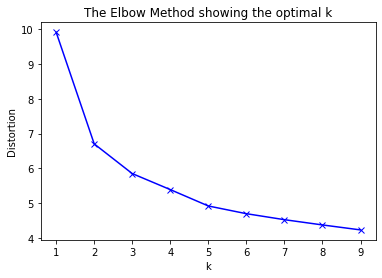

In [196]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(paris_grouped_sorted_means)
    kmeanModel.fit(paris_grouped_sorted_means)
    distortions.append(sum(np.min(cdist(paris_grouped_sorted_means, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / paris_grouped_sorted_means.shape[0])

# Plot the elbow
pyplot.plot(K, distortions, 'bx-')
pyplot.xlabel('k')
pyplot.ylabel('Distortion')
pyplot.title('The Elbow Method showing the optimal k')
pyplot.show()

In [197]:
kclusters = 3

Paris_grouped_clustering = paris_grouped_sorted_means

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:150] 

array([2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 0, 1, 0, 1, 0, 2, 1,
       1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 2, 0, 0, 0, 2,
       1, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2,
       0, 0, 2, 1, 0, 0, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0,
       2, 0, 0, 2, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2,
       2, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [198]:
paris_venues_gps_grouped.insert(0, 'cluster_label', kmeans.labels_)
paris_venues_gps_grouped

,cluster_label,commune_name,postal_code,latitude,longitude,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,...,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
0,2,Athis-Mons,91027,48.708325,2.389475,1,0,0,0,0,...,0,0,0,0,0,0,3,4,2,1
1,2,Juvisy-sur-Orge,91326,48.688555,2.377236,1,0,0,0,0,...,1,0,0,0,0,0,4,7,2,0
2,2,Morangis,91432,48.706539,2.335150,0,0,0,0,0,...,0,0,0,0,0,1,1,3,0,0
3,2,Paray-Vieille-Poste,91479,48.708334,2.362312,1,0,0,0,0,...,0,0,0,0,0,0,2,6,0,1
4,2,Savigny-sur-Orge,91589,48.674179,2.352795,0,0,0,0,0,...,0,0,0,0,0,1,3,8,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,Paris 16e Arrondissement,75116,48.854928,2.255330,0,3,3,0,2,...,3,0,8,0,2,4,4,17,3,0
146,1,Paris 17e Arrondissement,75117,48.881367,2.308816,0,2,3,1,2,...,4,0,3,0,0,9,2,27,4,1
147,1,Paris 18e Arrondissement,75118,48.887368,2.353412,0,2,1,0,1,...,2,0,3,0,0,9,4,29,6,0
148,1,Paris 19e Arrondissement,75119,48.878076,2.376198,1,0,2,0,1,...,3,0,3,0,2,7,1,38,5,0


In [199]:
# create map

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_venues_gps_grouped['latitude'], paris_venues_gps_grouped['longitude'], paris_venues_gps_grouped['commune_name'], paris_venues_gps_grouped['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mapGreater_Paris)
       
mapGreater_Paris

In [200]:
#Get average prices of the communities of ile de France
url_commune_avg_prices="https://www.data.gouv.fr/fr/datasets/r/36bb13d0-6cac-4540-b8b9-67c2162661ba"
avg_prices=pd.read_csv(url_commune_avg_prices,sep=';')
avg_prices = avg_prices[['INSEE_COM','PrixMoyen_M2']]
avg_prices.columns = ['postal_code','avg_price']
avg_prices.head()

,postal_code,avg_price
0,32216,NaN
1,47033,1421.0
2,32009,NaN
3,38225,2667.0
4,62890,967.0


In [201]:
# Get the avg Prices of the Greater Paris 
gp_avg_price = pd.merge(gp_df, avg_prices, on='postal_code')
gp_avg_price.dropna(axis='columns')
gp_avg_price.head()

,commune_name,postal_code,avg_price
0,Paris 1er Arrondissement,75101,10969.0
1,Paris 2e Arrondissement,75102,10833.0
2,Paris 3e Arrondissement,75103,11144.0
3,Paris 4e Arrondissement,75104,11681.0
4,Paris 5e Arrondissement,75105,11290.0


In [202]:
#Get the final dataframe with all communities of Greater Paris with their average prices and gps coordinates
gp_communities_price_gps = pd.merge(gp_avg_price, gps_communes, on='postal_code')
gp_communities_price_gps.head()

,commune_name_x,postal_code,avg_price,commune_name_y,latitude,longitude
0,Paris 1er Arrondissement,75101,10969.0,Paris 1er Arrondissement,48.863449,2.348751
1,Paris 2e Arrondissement,75102,10833.0,Paris 2e Arrondissement,48.867684,2.343126
2,Paris 3e Arrondissement,75103,11144.0,Paris 3e Arrondissement,48.861647,2.361319
3,Paris 4e Arrondissement,75104,11681.0,Paris 4e Arrondissement,48.856124,2.357453
4,Paris 5e Arrondissement,75105,11290.0,Paris 5e Arrondissement,48.852853,2.346502


Text(0.5, 1.0, 'avg_price bins')

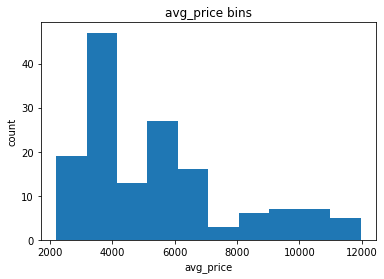

In [203]:
pyplot.hist(gp_communities_price_gps["avg_price"])

# set x/y labels and plot title
pyplot.xlabel("avg_price")
pyplot.ylabel("count")
pyplot.title("avg_price bins")

In [204]:
bins = np.linspace(min(gp_communities_price_gps["avg_price"]), max(gp_communities_price_gps["avg_price"]), 6)
bins

array([ 2193. ,  4147.4,  6101.8,  8056.2, 10010.6, 11965. ])

In [205]:
group_names = ['Low 1','Low 2','Medium','High','Very High']

In [206]:
gp_communities_price_gps["avg_price-binned"] = pd.cut(gp_communities_price_gps["avg_price"], bins, labels=group_names, include_lowest=True )
gp_communities_price_gps[['avg_price','avg_price-binned']].head(5)

,avg_price,avg_price-binned
0,10969.0,Very High
1,10833.0,Very High
2,11144.0,Very High
3,11681.0,Very High
4,11290.0,Very High


Text(0.5, 1.0, 'avg_price bins')

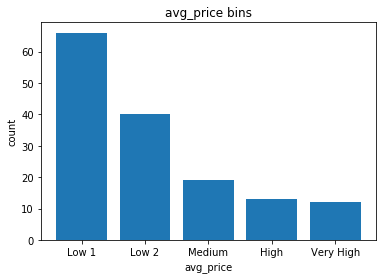

In [207]:
pyplot.bar(group_names, gp_communities_price_gps["avg_price-binned"].value_counts())

# set x/y labels and plot title
pyplot.xlabel("avg_price")
pyplot.ylabel("count")
pyplot.title("avg_price bins")

In [208]:
# create map of Greater Paris using latitude and longitude values
address = 'Paris'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

mapGreater_Paris_avg_price = folium.Map(location=[latitude, longitude], zoom_start=10)
mapGreater_Paris_avg_price.choropleth(
    geo_data=output_json,
    data=gp_communities_price_gps,
    columns=['postal_code', 'avg_price'],
    key_on='feature.properties.code',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.3,
    legend_name='Average Price'
)
mapGreater_Paris_avg_price

In [209]:
mapGreater_Paris_avg_price_clustered = mapGreater_Paris_avg_price
for lat, lon, poi, cluster in zip(paris_venues_gps_grouped['latitude'], paris_venues_gps_grouped['longitude'], paris_venues_gps_grouped['commune_name'], paris_venues_gps_grouped['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mapGreater_Paris_avg_price_clustered)
       
mapGreater_Paris_avg_price_clustered

In [210]:
kclusters_2 = 5

Paris_grouped_clustering_2 = paris_grouped_sorted_means

# run k-means clustering
kmeans_2 = KMeans(n_clusters=kclusters_2, random_state=0).fit(Paris_grouped_clustering_2)

# check cluster labels generated for each row in the dataframe
kmeans_2.labels_[0:150] 

array([2, 2, 2, 2, 0, 0, 0, 1, 4, 1, 3, 0, 0, 4, 0, 4, 1, 4, 1, 0, 0, 1,
       4, 4, 1, 3, 2, 0, 3, 4, 1, 0, 4, 4, 4, 0, 4, 1, 3, 2, 0, 4, 4, 0,
       3, 2, 4, 0, 0, 2, 2, 0, 4, 2, 0, 0, 0, 4, 3, 2, 2, 4, 0, 0, 0, 0,
       4, 0, 2, 3, 4, 4, 0, 0, 1, 2, 2, 2, 2, 4, 2, 0, 2, 4, 0, 2, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 4, 0, 3, 0, 4, 4, 4, 2, 4, 2, 2, 4, 2, 2, 2,
       2, 4, 2, 2, 2, 3, 4, 4, 2, 2, 0, 2, 2, 4, 2, 0, 0, 1, 0, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 3, 3, 3, 4, 1, 1, 1, 1], dtype=int32)

In [211]:
paris_venues_gps_grouped_2 =  paris_venues_gps_grouped
paris_venues_gps_grouped_2.insert(0, 'cluster_label_2', kmeans_2.labels_)
paris_venues_gps_grouped_2 = paris_venues_gps_grouped.drop(columns=['cluster_label'])
paris_venues_gps_grouped_2

,cluster_label_2,commune_name,postal_code,latitude,longitude,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,...,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
0,2,Athis-Mons,91027,48.708325,2.389475,1,0,0,0,0,...,0,0,0,0,0,0,3,4,2,1
1,2,Juvisy-sur-Orge,91326,48.688555,2.377236,1,0,0,0,0,...,1,0,0,0,0,0,4,7,2,0
2,2,Morangis,91432,48.706539,2.335150,0,0,0,0,0,...,0,0,0,0,0,1,1,3,0,0
3,2,Paray-Vieille-Poste,91479,48.708334,2.362312,1,0,0,0,0,...,0,0,0,0,0,0,2,6,0,1
4,0,Savigny-sur-Orge,91589,48.674179,2.352795,0,0,0,0,0,...,0,0,0,0,0,1,3,8,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,4,Paris 16e Arrondissement,75116,48.854928,2.255330,0,3,3,0,2,...,3,0,8,0,2,4,4,17,3,0
146,1,Paris 17e Arrondissement,75117,48.881367,2.308816,0,2,3,1,2,...,4,0,3,0,0,9,2,27,4,1
147,1,Paris 18e Arrondissement,75118,48.887368,2.353412,0,2,1,0,1,...,2,0,3,0,0,9,4,29,6,0
148,1,Paris 19e Arrondissement,75119,48.878076,2.376198,1,0,2,0,1,...,3,0,3,0,2,7,1,38,5,0


In [212]:
mapGreater_Paris_avg_price_clustered_2 = mapGreater_Paris_avg_price

x_2 = np.arange(kclusters_2)
ys_2 = [i + x + (i*x)**2 for i in range(kclusters_2)]
colors_array_2 = cm.rainbow(np.linspace(0, 1, len(ys_2)))
rainbow_2 = [colors.rgb2hex(i) for i in colors_array_2]

for lat, lon, poi, cluster in zip(paris_venues_gps_grouped_2['latitude'], paris_venues_gps_grouped_2['longitude'], paris_venues_gps_grouped_2['commune_name'], paris_venues_gps_grouped_2['cluster_label_2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow_2[cluster-1],
        fill=True,
        fill_color=rainbow_2[cluster-1],
        fill_opacity=0.7).add_to(mapGreater_Paris_avg_price_clustered_2)
       
mapGreater_Paris_avg_price_clustered_2

In [213]:
cluster0 = paris_venues_gps_grouped_2.loc[paris_venues_gps_grouped_2['cluster_label_2'] == 0]
cluster0 = cluster0.drop(columns=['cluster_label_2','latitude','longitude'])
cluster0.head(5)

,commune_name,postal_code,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,Health Food Store,High School,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
4,Savigny-sur-Orge,91589,0,0,0,0,0,0,3,0,0,0,0,0,1,3,8,3,0
5,Viry-Châtillon,91687,0,0,0,0,0,0,3,0,0,0,0,0,1,1,9,2,0
6,Antony,92002,0,0,0,0,0,0,0,1,0,0,0,0,6,1,10,5,0
11,Bourg-la-Reine,92014,1,0,0,0,0,0,3,2,0,0,0,0,3,3,7,4,0
12,Châtenay-Malabry,92019,1,0,0,0,0,0,2,0,0,0,0,0,7,0,7,2,0


In [219]:
cluster1 = paris_venues_gps_grouped_2.loc[paris_venues_gps_grouped_2['cluster_label_2'] == 1]
cluster1 = cluster1.drop(columns=['cluster_label_2','latitude','longitude'])
cluster1.head(10)

,commune_name,postal_code,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,Health Food Store,High School,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
7,Asnières-sur-Seine,92004,0,1,0,0,1,1,2,2,0,4,1,0,9,3,29,3,0
9,Bois-Colombes,92009,0,1,0,0,0,0,1,0,0,3,0,0,8,2,25,3,1
16,Clichy,92024,0,1,0,1,2,0,1,4,0,3,1,0,10,3,26,5,1
18,Courbevoie,92026,1,1,1,0,1,0,1,4,0,3,0,0,15,5,19,4,4
21,La Garenne-Colombes,92035,1,0,1,0,1,0,1,2,0,2,0,0,12,7,22,5,6
24,Levallois-Perret,92044,0,2,2,1,2,0,3,7,0,3,1,0,10,3,26,2,1
30,Neuilly-sur-Seine,92051,1,3,0,0,2,0,2,7,0,7,0,0,15,4,20,1,0
37,Suresnes,92073,3,1,2,0,0,0,2,1,0,0,0,0,8,4,23,3,3
74,Saint-Ouen-sur-Seine,93070,1,0,1,0,2,0,0,5,0,3,0,0,10,4,30,2,1
127,Vincennes,94080,0,2,0,0,0,1,1,0,0,6,0,0,3,6,25,2,0


In [215]:
cluster2 = paris_venues_gps_grouped_2.loc[paris_venues_gps_grouped_2['cluster_label_2'] == 2]
cluster2 = cluster2.drop(columns=['cluster_label_2','latitude','longitude'])
cluster2.head(5)

,commune_name,postal_code,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,Health Food Store,High School,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
0,Athis-Mons,91027,1,0,0,0,0,0,1,0,0,0,0,0,0,3,4,2,1
1,Juvisy-sur-Orge,91326,1,0,0,0,0,0,0,1,0,0,0,0,0,4,7,2,0
2,Morangis,91432,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,0,0
3,Paray-Vieille-Poste,91479,1,0,0,0,0,0,0,0,0,0,0,0,0,2,6,0,1
26,Marnes-la-Coquette,92047,0,0,0,0,0,0,0,1,0,0,0,0,3,2,6,3,0


In [216]:
cluster3 = paris_venues_gps_grouped_2.loc[paris_venues_gps_grouped_2['cluster_label_2'] == 3]
cluster3 = cluster3.drop(columns=['cluster_label_2','latitude','longitude'])
cluster3.head(5)

,commune_name,postal_code,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,Health Food Store,High School,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
10,Boulogne-Billancourt,92012,1,1,3,0,1,0,2,2,0,7,0,1,12,5,20,2,7
25,Malakoff,92046,0,0,0,0,4,0,0,3,0,7,0,0,6,3,19,2,8
28,Montrouge,92049,1,1,2,0,3,0,0,4,0,8,0,0,6,3,20,3,8
38,Vanves,92075,0,0,1,0,3,1,0,2,0,6,0,0,9,4,19,2,11
44,Bagnolet,93006,2,1,1,0,0,1,0,5,0,15,0,1,9,5,27,0,5


In [217]:
cluster4 = paris_venues_gps_grouped_2.loc[paris_venues_gps_grouped_2['cluster_label_2'] == 4]
cluster4 = cluster4.drop(columns=['cluster_label_2','latitude','longitude'])
cluster4.head(5)

,commune_name,postal_code,Bus Station,Convenience Store,Elementary School,Garden,Grocery Store,Health Food Store,High School,Hospital,Medical Center,Metro Station,Middle School,Nursery School,Park,Pharmacy,Supermarket,Train Station,Tram Station
8,Bagneux,92007,1,1,0,0,0,0,1,1,0,1,0,0,7,2,16,5,2
13,Châtillon,92020,2,0,0,0,0,0,1,0,0,2,0,0,5,1,18,3,4
15,Clamart,92023,3,0,0,0,0,0,1,2,0,0,0,0,4,1,16,2,2
17,Colombes,92025,0,0,1,0,0,0,1,2,0,0,0,0,9,4,19,3,3
22,Gennevilliers,92036,1,1,0,0,0,0,0,1,0,3,0,1,5,2,23,2,6
